In [97]:
%matplotlib inline
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from island import Island
from geometry import *
from continuum import Continuum
plt.rcParams['figure.figsize'] = [6, 4.5]
hfont = {'fontname':'Helvetica'}

# Continuum with an island chain - benchmark

We want to benchmark our code with the result of the following paper:

1. C. R. Cook and C. C. Hegna, Analytical Theory of the Shear Alfvén Continuum in the Presence of a Magnetic Island, Phys. Plasmas 22, 042517 (2015).


## 1. Set up

- Aspect ratio large - let R0 = 100
- Small island width


In [71]:
R0 = 1000
m0 = 5
n0 = 2
q0 = m0 / n0
qprime = 4
psi0 = 0.4
geo = ToroidalGeometry(a=1, R0=R0, B0=1)
A = 0.00001
myisland = Island(geo, m0=m0, n0=n0, psi0=psi0, qprime=qprime, A=A)

#### q profile outside island

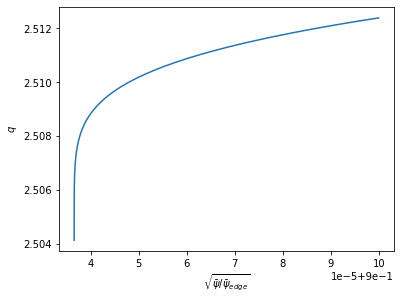

In [72]:
chilistplus = -A - 0.01*A * np.exp(-np.linspace(0,16,401))
psibarplus,Omega, qplus = myisland.get_psibar_omega_q_passing(chilistplus, sign=1)


plt.plot(np.sqrt(psibarplus/0.5), qplus)
plt.xlabel(r"$\sqrt{\bar{\psi}/\bar{\psi}_{edge}}$")
_ = plt.ylabel(r"$q$")

#### $\Omega$ inside the island w.r.t. the centre of the island

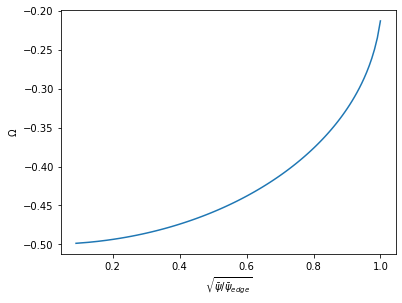

In [73]:
q0 = m0 / n0
qprime=4
w = 4 * np.sqrt(A * (q0)**2 / qprime)
eps = qprime * w / 2

chilist = -A + 0.01*A * np.exp(-np.linspace(0,16,401))
chilistfqc = -A + 2 * A * np.linspace(0, 1, 100)[1:-1]
psitrapped,Omegat, qt = myisland.get_psibar_omega_q_trapped(chilistfqc)

psiedge = np.max(np.abs(psitrapped))

plt.plot(np.sqrt(psitrapped/psiedge), 1 / qt / n0  * q0 / eps  )

plt.xlabel(r"$\sqrt{\bar{\psi}/\bar{\psi}_{edge}}$")
_ = plt.ylabel(r"$\Omega$")

## 2. Continuum

We will need n=0

In [74]:
mycont_pass = Continuum(myisland, mstart=-7*m0, mcount=15, nstart=-7*n0, ncount=15,  mfp=m0, nfp=n0)
mycont_trap = Continuum(myisland, mstart=-7, mcount=15, nstart=0, ncount=1,  mfp=1, nfp=n0)

In [75]:
psibar1, omega1 = mycont_pass.compute_continuum(chilistplus, passing=True, sign=1)
psibar2, omega2 = mycont_trap.compute_continuum(chilist, passing=False)

omega1 *= R0**2
omega2 *= R0**2

In [48]:
q0 = m0 / n0
qprime=4
w = 4 * np.sqrt(A * (q0)**2 / qprime)
wcap = w * qprime / np.sqrt(32)

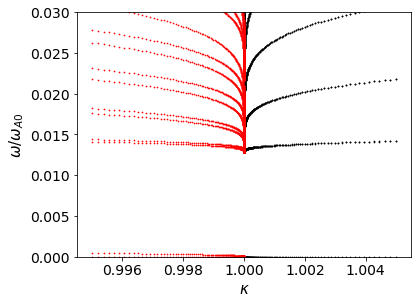

In [80]:
kappaplus = (np.abs(chilistplus) + A)/(2 * A)
kappatrap = (np.abs(chilist) + A)/(2 * A)
plt.scatter(np.broadcast_to(kappaplus[:,None], omega1.shape), np.sqrt(np.abs(omega1)), s=0.5, c='k')
plt.scatter(np.broadcast_to(kappatrap[:,None], omega2.shape), np.sqrt(np.abs(omega2)), s=0.5, c='r')

plt.ylim([0.0,0.03])
plt.xlabel(r"$\kappa$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('CAP.png', dpi=300, bbox_inches='tight')

## Scan of the accumulation point

In [94]:
Alist = np.linspace(0.000001, np.sqrt(0.0001), 10) ** 2
mlist = np.array([5, 7])
nlist = np.array([2, 3])
chilistexp = np.array([15])
wcap_theory = np.zeros([Alist.size, mlist.size])
wcap_code = np.zeros([Alist.size, mlist.size])

for i in range(Alist.size):
    for j in range(mlist.size):
        R0 = 1000
        qprime = 4
        m0 = mlist[j]
        n0 = nlist[j]
        q0 = m0 / n0
        psi0 = 0.4
        geo = ToroidalGeometry(a=1, R0=R0, B0=1)
        A = Alist[i]
        myisland = Island(geo, m0=m0, n0=n0, psi0=0.4, qprime=qprime, A=A)
        chilist = -A + 0.01*A * np.exp(-chilistexp)
        kappatrap = (np.abs(chilist) + A)/(2 * A)
        mycont_trap = Continuum(myisland, mstart=-100, mcount=201, nstart=0, ncount=1,  mfp=1, nfp=1)

        psibar2, omega2 = mycont_trap.compute_continuum(chilist, passing=False)
        omega2 *= R0**2

        psitrapped,Omegat, qt = myisland.get_psibar_omega_q_trapped(chilist)

        wcap_code[i,j] = np.sqrt(omega2[-1, 3])

        w = 4 * np.sqrt(A * (q0)**2 / qprime)

        wcap_theory[i, j] = w * qprime * n0  / q0 / 4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


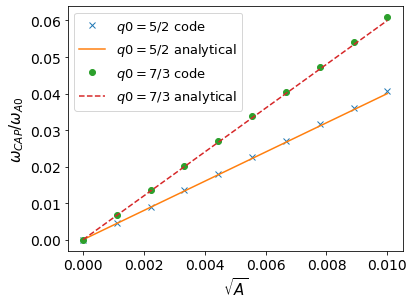

In [102]:
plt.plot(np.sqrt(Alist), wcap_code[:,0], 'x')
plt.plot(np.sqrt(Alist), wcap_theory[:,0], '-'  )
plt.plot(np.sqrt(Alist), wcap_code[:,1], 'o')
plt.plot(np.sqrt(Alist), wcap_theory[:,1], '--'  )

plt.xlabel(r"$\sqrt{A}$", fontsize=15)
plt.ylabel(r"$\omega_{CAP} / \omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([r"$q0=5/2$ code", r"$q0=5/2$ analytical", r"$q0=7/3$ code", r"$q0=7/3$ analytical"], fontsize=13)
plt.savefig('benchmark.eps', bbox_inches='tight')